In [8]:
pip install sentencepiece wandb accelerate -U rouge_score evaluate

Note: you may need to restart the kernel to use updated packages.


In [9]:
import wandb
import nltk
import json
from pprint import pprint
import evaluate
import torch
import numpy as np
from datasets import load_dataset
from transformers import T5Tokenizer, DataCollatorForSeq2Seq
from transformers import T5ForConditionalGeneration, Seq2SeqTrainingArguments, Seq2SeqTrainer, AutoModelForSeq2SeqLM
from datasets import load_from_disk
from peft import  PeftModel


For test we will use the data from train dataset

In [10]:
load_directory_raw = "datasets/raw/"
dataset_dict = load_from_disk(load_directory_raw)

load_directory_token = "datasets/tokenized/"
tokenized_dataset =load_from_disk(load_directory_token)

## Load tokenizer and models

In [11]:
# Load tokenizer and models
MODEL_PT_NAME = "google/flan-t5-small"
tokenizer = T5Tokenizer.from_pretrained(MODEL_PT_NAME)
model_pretrained = AutoModelForSeq2SeqLM.from_pretrained(MODEL_PT_NAME)
last_checkpoint_ft_small = "./results/comic-pond-13/checkpoint-160/"
model_finetuned = T5ForConditionalGeneration.from_pretrained(last_checkpoint_ft_small)
model_peft_base = AutoModelForSeq2SeqLM.from_pretrained("google/flan-t5-base", torch_dtype=torch.bfloat16)

model_peft = PeftModel.from_pretrained(model_peft_base, 'PEFT-FLAN-T5-Base', torch_dtype=torch.bfloat16, is_trainable=False)



Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [12]:
dataset_dict

DatasetDict({
    train: Dataset({
        features: ['input', 'ideal', '__index_level_0__'],
        num_rows: 100
    })
    test: Dataset({
        features: ['input', 'ideal', '__index_level_0__'],
        num_rows: 26
    })
})

In [13]:
tokenized_dataset

DatasetDict({
    train: Dataset({
        features: ['input', 'ideal', '__index_level_0__', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 100
    })
    test: Dataset({
        features: ['input', 'ideal', '__index_level_0__', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 26
    })
})

In [14]:
#test prompt 
prompt='Summarize the following document: ServicesGermany--Dynamics 365 GermanyAustralia--AX Integration Australia--Dynamics 365 AustraliaUnited Kingdom--AX Integration--AX MobilityIndustries--Animal Management--Food & Agriculture--Retail & Ecommerce--PartnerDynamics 365--Dynamics Business Central--Microsoft Dynamics 365--Dynamics 365 Implementation--Dynamics 365 Ecommerce--Dynamics 365 Migration--Dynamics 365 Applications--FastTrack HR Payroll--FastTrack Finance & OperationsMobile Apps--Microsoft Dynamics AX CRM Mobile App--AX D365 Workflow Approvals App--AX D365 Warehouse Management App--AX D365 2012 Timesheet App--AX D365 2012 Expenses AppConnectors--Magento Connector--Shopify Connector--WooCommerce Connector--Amazon Connector--Salesforce Connector--Ebay ConnectorAX DevelopmentAX CustomizationAX IntegrationAX Business IntelligenceAX Loyalty Management Solution--AX Loyalty Management AppDynamics NAVD365 Integration--Dynamics NAV Magento--Dynamics NAV ShopifyTroubled Implementation--Dynamics AX Security Review--Dynamics AX Technical Training--Dynamics AX Functional Training--Dynamics AX Performance ImprovementSolutions--AgriERP--Retail POS & Campaign ManagementOther By submitting this form, you are agreeing to Folio3s Privacy Policy and Terms of Service. ## Get a free Consultation Products Solutions By Solution By Initiative By Mobility By Industry Training & Support Integration Company # What Is The Primary Goal Of Business Continuity Planning By January 23, 2024 #### Table of contents What Is Business Continuity Business Continuity Solutions Business Continuity Strategy What Is A Business Continuity Plan Business Continuity Plan Template Business Continuity Planning Business Continuity Plan Example What Is The Primary Goal Of Business Continuity Planning What Is A Business Continuity Planner Disaster Recovery and Business Continuity Plan How To Write A Business Continuity Plan How Often Should A Business Continuity Plan Be Tested Advantages of Business Continuity Planning Disadvantages of Having a Business Continuity Planning Importance of Business Continuity Planning Business Continuity Certification Companies That Provide Business Continuity Services What Is Business Continuity And Resiliency Services Business Continuity Management System Business Continuity Management Software What Is Business Continuity Management What is Business Continuity Management Framework What is Business Continuity Management Policy What is a Business Continuity Management Plan What is Business Continuity and Crisis Management What is business continuity exactly If you dont know, there is no need to worry because we will be covering every aspect of business continuity in this post. Ranging from the definition to management system and continuity plan to processes, we are going to shed a spotlight on everything. But before we do that, let us tell you that access to business continuity plans is beneficial for</s>'

### Using Pre-Trained model for baseground evaluation

In [15]:

inputs_pretrained = tokenizer(prompt, return_tensors="pt", truncation=True, max_length=300)
output_pretrained = model_pretrained.generate(**inputs_pretrained,min_length=200, early_stopping=False, no_repeat_ngram_size=2, max_length = 600)
pretrained_answer = tokenizer.decode(output_pretrained[0], skip_special_tokens=True)
pretrained_answer

'Software and services of the company. Software, services and products of a company, company or company based in Germany. - Software & services for ecommerce, retail, and retail. Services and product and service of services. Products and Services of companies. Product and Service of products and/or services. Service and Product of service. Company. product of company and company in the world. Customer. service and customer service in europe. Country. country. region.. continent., continent, region, country, nation, state, federation, united kingdom. United Kingdom. Europe. America. Africa. Asia. Australia. Canada. China. India. Russia. Japan. France. Germany, Canada, United States. Spain. Italy. Switzerland. Sweden. Denmark. Ireland. Netherlands. Poland. Portugal. Romania. Austria. Belgium. Hungary. Greece. Turkey. Ukraine. USA. Mexico. Brazil. Argentina. Chile. Colombia. Venezuela. Iran.'

# Apply Fine Tuned FLAN-T5-small model

In [16]:

inputs_ft = tokenizer(prompt, return_tensors="pt", truncation=True, max_length=500)
output_ft = model_finetuned.generate(**inputs_ft,  min_length=200, early_stopping=False, no_repeat_ngram_size=2, max_length = 600)
answer_ft = tokenizer.decode(output_ft[0], skip_special_tokens= True)
pprint(answer_ft)


('This document is a document titled "What Is the Primary Goal Of Business '
 'Continuity Planning" by Microsoft. It discusses business continuity '
 'planning, including the primary goal of achieving business continuity. The '
 'document discusseses the importance of business succession planning and the '
 'role of the company in ensuring that business is managed efficiently and '
 'efficiently. Key points from the document include: - The primary objective '
 'of Business continuity is to ensure that businesses are managed effectively '
 'and effectively. – The main objective is the business leadership strategy, '
 'which includes the management of businesses, the development of companies, '
 "and implementing companies' policies. In conclusion, this document provides "
 'supplemental information on business management and business planning. This '
 'includes identifying the key points of key business objectives, establishing '
 "efficiencies, improving business processes, managing bu

# Define evaluate helper functions

In [17]:
from rouge_score import rouge_scorer
import json
from textwrap import fill
from rouge_score import rouge_scorer
from textwrap import fill

def compare_rouge_scores(answer1, answer2, label, key1str="Answer 1", key2str="Answer 2"):
    scorer = rouge_scorer.RougeScorer(['rouge2', 'rouge2', 'rougeL'], use_stemmer=True)
    scores_answer1 = scorer.score(answer1, label)
    scores_answer2 = scorer.score(answer2, label)
    
    # Create a dictionary to store the scores
    scores_data = {
        key1str: {
            "ROUGE-2": scores_answer1['rouge2']
        },
        key2str: {
            "ROUGE-2": scores_answer2['rouge2']
        }
    }
    
    print(json.dumps(scores_data, indent=4))
    
    return scores_answer1, scores_answer2


def generate_output(prompt, model, tokenizer):
    inputs = tokenizer(prompt, return_tensors="pt", truncation=True, max_length=200)

    
    outputs = model.generate(**inputs, min_length=200, early_stopping=False, no_repeat_ngram_size=2, max_length = 600)
   
    
    answer = tokenizer.decode(outputs[0], skip_special_tokens=True)
    
    return answer

def visualize_outputs(answer1, answer2, key1str: str, key2str: str):
    output_data = {
        f"{key1str} Model Output": fill(answer1, width=80),
        f"{key2str} Model Output": fill(answer2, width=80)
    }

    print(json.dumps(output_data, indent=4))

def evaluate_models(prompt, answer1, answer2, ideal, key1str: str, key2str: str, should_print=False):
    if should_print:
        visualize_outputs(answer1, answer2, key1str, key2str)  

    scores = compare_rouge_scores(answer1, answer2, ideal, key1str, key2str)

    return scores

## Test and compare Fine Tuned Small model and Pre-trained model

In [18]:

prompt = tokenizer.decode(tokenized_dataset['test']['input_ids'][23])
true_label = tokenized_dataset['test']['ideal'][23]

fine_tuned_answer = generate_output(prompt, model_finetuned, tokenizer)
pprint(f"FT: {fine_tuned_answer}")
pre_trained_answer = generate_output(prompt, model_pretrained, tokenizer)
pprint(f"PRE : {pre_trained_answer}")
scores = evaluate_models(prompt,fine_tuned_answer, pre_trained_answer, true_label, key1str ='fine_tuned_answer', key2str = 'pre_trained_answer')
print(scores)

('FT: This document is an article titled "Taming Network Complexity with '
 'Digital Twins" by Informa Network Computing. It discusses the role of '
 'digital twins in managing and troubleshooting complex networks, including '
 'the use of virtual replicas to replicate the network configuration and '
 'state. The article discusse the importance of a virtual replicate in '
 'ensuring that digital Twin is able to be used in manufacturing. Key points '
 'from the article include: - The use and use by digital hybrids of the '
 'digital network are essential. – The role and uses of Digital twin in the '
 'management of complex network networks is essential, and the need for '
 'digital replicating is crucial. In conclusion, the document highlights the '
 'potential of artificial intelligence (AI) to help manage and Troubleshoost '
 'complex systems. This article highlights how digital dual-switching networks '
 'can help control and restore network performance. Overall, it emphasizes how '


# Evaluation for PEFT FLAN-T5-Base

In [19]:

from peft import PeftModel, PeftConfig
from transformers import AutoTokenizer

from rouge_score import rouge_scorer
from textwrap import fill

tokenizer = AutoTokenizer.from_pretrained("google/flan-t5-base")


As observed, the performance of the PEFT model was significantly superior, with the ROUGE-2 score being considerably higher than that of the smaller model.

In [20]:

peft_answer = generate_output(prompt, model_peft, tokenizer)
pprint(f"PEFT ANSWER: ###{peft_answer}")
fine_tuned_answer_small = generate_output(prompt, model_finetuned, tokenizer)
pprint(f"FINE TUNED SMALL MODEL ANSWER : ###{fine_tuned_answer_small}")

scores = evaluate_models(prompt, peft_answer,fine_tuned_answer_small, true_label, 'peft_answer', 'fine_tuned_answer_small')



('PEFT ANSWER: ###This document is an article titled "Taming Network '
 'Complexity with Digital Twins" by Informa Network Computing. It discusses '
 'the use of digital twins in managing and troubleshooting complex networks. '
 'The article highlights the importance of virtual replicas of physical '
 'systems, such as jet engines or machines, to managing network complexity. '
 'Key points from the article include: - Digital twin technology is becoming '
 'more popular in the context of manufacturing, where virtual replicates mimic '
 'physical system workings. – Digital replica technology can help manage and '
 'Troubleshook network complexities by providing an accurate replica of the '
 'networks configuration and state. This article emphasizes that digital '
 'replica technologies are becoming increasingly popular, and there is a '
 'growing interest in digital Twin technology. In conclusion, the document '
 'highlights how digital hybrids can be used to manage network problems and 

As we see, rouge2 score in comparison to pretrained model is even higher

In [21]:

#fine_tuned_answer_base = generate_output(prompt, model_finetuned, tokenizer)
pprint(f"PEFT: {peft_answer}")
#pre_trained_answer = generate_output(prompt, model_pretrained, tokenizer)
pprint(f"PRE : {pretrained_answer}")
scores = evaluate_models(prompt, peft_answer, pretrained_answer, true_label, 'peft_answer', 'pretrained_answer')
pprint(scores)

('PEFT: This document is an article titled "Taming Network Complexity with '
 'Digital Twins" by Informa Network Computing. It discusses the use of digital '
 'twins in managing and troubleshooting complex networks. The article '
 'highlights the importance of virtual replicas of physical systems, such as '
 'jet engines or machines, to managing network complexity. Key points from the '
 'article include: - Digital twin technology is becoming more popular in the '
 'context of manufacturing, where virtual replicates mimic physical system '
 'workings. – Digital replica technology can help manage and Troubleshook '
 'network complexities by providing an accurate replica of the networks '
 'configuration and state. This article emphasizes that digital replica '
 'technologies are becoming increasingly popular, and there is a growing '
 'interest in digital Twin technology. In conclusion, the document highlights '
 'how digital hybrids can be used to manage network problems and improve '


# Data visualization and Conclusion

In [39]:
import numpy as np

def prepare_data(tokenizer, tokenized_dataset, num_samples=5):
    """
    Prepare prompts and corresponding true labels for model evaluation.
    
    Args:
    tokenizer (Tokenizer): The tokenizer used for encoding the data.
    tokenized_dataset (Dataset): The tokenized dataset containing input IDs and labels.
    num_samples (int): Number of samples to prepare.
    
    Returns:
    A tuple containing two lists - prompts and true_labels.
    """
    prompts = []
    true_labels = []

    num_samples = min(num_samples, len(tokenized_dataset['train']))

    for i in range(num_samples):
        prompt = tokenizer.decode(tokenized_dataset['train']['input_ids'][i], skip_special_tokens=True)
        
        true_label = tokenizer.decode(tokenized_dataset['train']['labels'][i], skip_special_tokens=True)

        prompts.append(prompt)
        true_labels.append(true_label)

    return prompts, true_labels

prompts, true_labels = prepare_data(tokenizer, tokenized_dataset, num_samples=50)


In [40]:
prompts

['Summarize the following document: Next Article in Journal Next Article in Special Issue Previous Article in Journal ## Journals ## ## Information ## ## Initiatives ## About ## Notice You can make submissions to other journals clear ## Notice You are accessing a machine-readable page. In order to be human-readable, please install an RSS reader. Continue Cancel clear All articles published by MDPI are made immediately available worldwide under an open access license. No special permission is required to reuse all or part of the article published by MDPI, including figures and tables. For articles published under an open access Creative Common CC BY license, any part of the article may be reused without permission provided that the original article is clearly cited. For more information, please refer to Feature papers represent the most advanced research with significant potential for high impact in the field. A Feature Paper should be a substantial original Article that involves severa

In [24]:
true_labels

['This document is a research article titled "Digital Twin Technology Challenges and Applications: A Comprehensive Review." The article provides a systematic literature review on the state of the art of digital twin (DT) technology and its implementation challenges and limits in various domains and applications. The article begins by introducing the concept of digital twins as virtual representations of physical objects or processes that collect information from the real environment to simulate and validate the behavior of their physical counterparts. It discusses the importance of DTs in data-driven decision making, complex systems monitoring, product validation, and lifecycle management. The methodology section describes the systematic literature review process, including the search criteria, protocol, and selection criteria for publications. The authors conducted a comprehensive search in various databases and selected relevant publications based on their application industries, suc

### Generate summaries lists

In [42]:
#pretrained_summaries = [generate_output(prompt, model_pretrained, tokenizer) for prompt in prompts]
finetuned_summaries = [generate_output(prompt, model_finetuned, tokenizer) for prompt in prompts]
peft_summaries = [generate_output(prompt, model_peft, tokenizer) for prompt in prompts]


In [26]:
pretrained_summaries

["Feature papers. Publish a specialized article. Write supplemental articles. Review scholarly articles and articles published by MDPI. Consider submitting supplementary articles to MDP. Read the articles in indexed journals. Use citations to identify the article's purpose. Include resale articles for upcoming publications. Provide cited articles with highlighting and citing articles that are based on the author' s research. Make recurring articles of interest. Reuse if necessary. Submit e-mail to mdp@dmp.com. Follow the on-line instructions on how to use TMP and MDIP. Visit the MDI website. Contact the editor of the journal. Request downloadable articles from the website and see whose articles are available. Click on 'Remove' or. Select. Choose __. Copy the Associated articles on your computer. Add /copy the text to the page.",
 "5G-ACIA is a key component of the Industrie 4.0 architecture. It supports the notion of working with digital twins of all assets of........, and i.e. 5g netw

In [27]:
finetuned_summaries

['This document is a document titled "Feature Papers" by the National Institute of Health and Human Services (NHH). It discusses the importance of promoting the use of the Internet in the treatment of diseases. The document discusseses the need for addressing the needs of patients in developing countries. It emphasizes that the NHHT is an important tool for improving the quality of life of people in their countries, and provides supplemental information on the impact of research on diseases and diseases in rural areas. In conclusion, the document provides an overview of how the internet works and how it can help improve the health of individuals in these countries and provide supplementary information about the benefits of using the online service. Specifically, it discussees how NDHS can improve their quality and effectiveness in reducing the risk of disease in patients. This article discussed the role of Internet service providers in providing healthcare services in improving quality

In [43]:
peft_summaries

["This document is an article published by MDPI, which is published immediately worldwide under an open access license. It provides information on the journal and its initiatives. The article is structured as follows: - Next Article in Journal : Next article in Special Issue. – Journals, Information & Initiatives: Notice! Submissions to other journals are allowed, including figures and tables, without permission. Please note that the article may be edited or reused without special permission, provided that it is clearly cited. For articles published under open Access Creative Common CC BY license, any part of the articles may still be reuseable without author's permission provided the original article has been cite. This article provides additional information about the publication of MDP' Feature Papers. In conclusion, the document provides an overview of how MDDP publishes its articles and provides a list of articles that can be used in various ways. Overall, this document serves as 

### Compute Rouge 2 scores

In [44]:
from evaluate import load

rouge = load('rouge')


def compute_rouge_scores(summaries, ideal_summaries):
    """
    Calculate and return the fmeasure for ROUGE-2 for each pair of summary and ideal summary
    """
    return [rouge.compute(predictions=[summary], references=[ideal], use_aggregator=True)['rouge2'] for summary, ideal in zip(summaries, ideal_summaries)]


# Computing ROUGE scores for each model
#pretrained_scores = compute_rouge_scores(pretrained_summaries, true_labels)
finetuned_scores = compute_rouge_scores(finetuned_summaries, true_labels)
peft_scores = compute_rouge_scores(peft_summaries, true_labels)

In [45]:
peft_scores

[0.045889101338432124,
 0.23868312757201646,
 0.1669902912621359,
 0.22810590631364558,
 0.15879017013232516,
 0.2787286063569683,
 0.13417190775681342,
 0.13025210084033612,
 0.1643192488262911,
 0.06386554621848739,
 0.09913793103448275,
 0.13435700575815737,
 0.29856115107913667,
 0.2,
 0.19631901840490795,
 0.16885553470919323,
 0.1670886075949367,
 0.12103746397694524,
 0.24528301886792453,
 0.27155172413793105,
 0.27713625866050806,
 0.1527093596059113,
 0.2398190045248869,
 0.1856060606060606,
 0.13250517598343686,
 0.2508591065292096,
 0.2622107969151671,
 0.27765726681127983,
 0.16145833333333331,
 0.046511627906976744,
 0.13999999999999999,
 0.14152700186219738,
 0.23266219239373603,
 0.04962779156327543,
 0.15196078431372548,
 0.21287128712871287,
 0.1297071129707113,
 0.026768642447418736,
 0.208955223880597,
 0.1914893617021277,
 0.04672897196261682,
 0.04395604395604396,
 0.1530864197530864,
 0.15789473684210525,
 0.2428842504743833,
 0.04670912951167727,
 0.1530864197530

In [ ]:
finetuned_scores

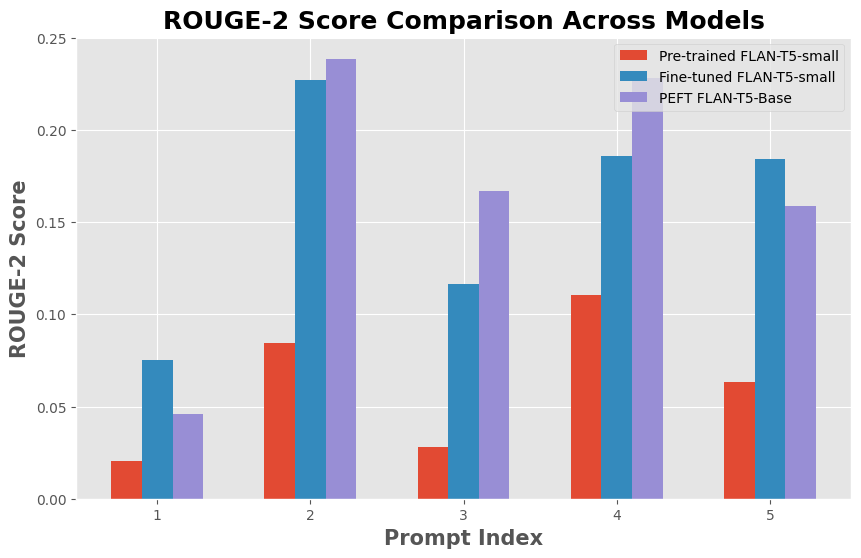

In [30]:
import matplotlib.pyplot as plt
import numpy as np

models = ['Pre-trained FLAN-T5-small', 'Fine-tuned FLAN-T5-small', 'PEFT FLAN-T5-Base']
scores = [pretrained_scores, finetuned_scores, peft_scores]

plt.style.use('ggplot')

fig, ax = plt.subplots(figsize=(10, 6))

width = 0.2       

ind = np.arange(len(prompts))

for i, model_scores in enumerate(scores):
    ax.bar(ind + i * width, model_scores, width, label=models[i])

ax.set_xlabel('Prompt Index', fontweight='bold', fontsize=15)
ax.set_xticks(ind + width)
ax.set_xticklabels([str(i) for i in range(1, len(prompts) + 1)])

ax.set_ylabel('ROUGE-2 Score', fontweight='bold', fontsize=15)


ax.set_title('ROUGE-2 Score Comparison Across Models', fontweight='bold', fontsize=18)

ax.legend(loc='best')

plt.show()


In [46]:
pretrained_scores

[0.020618556701030927,
 0.08425720620842574,
 0.028011204481792718,
 0.11040339702760085,
 0.06329113924050633]

In [33]:
# # Assuming `results` is a dictionary with models as keys and another dictionary as values, which contains lists of scores for 'rouge1', 'rouge2', 'rougeL'
# original_model_results = results['Pretrained']
# instruct_model_results = results['Fine-Tuned Small']
# peft_model_results = results['PEFT']

# # Calculate improvements
# original_improvements = calculate_improvement(instruct_model_results, original_model_results)
# peft_improvements = calculate_improvement(peft_model_results, instruct_model_results)

# # Print improvements
# print_improvements(original_improvements, "Fine-Tuned Small", "Pretrained")
# print_improvements(peft_improvements, "PEFT", "Fine-Tuned Small")

NameError: name 'results' is not defined

In [50]:
def calculate_improvement(new_model_scores, baseline_scores):
    # Assuming that new_model_scores and baseline_scores are lists of the same length
    improvements = [
        (new - base) / base * 100 for new, base in zip(new_model_scores, baseline_scores)
    ]
    return improvements

def print_improvements(improvements, model_name, baseline_name):
    print(f"Improvement of {model_name} over {baseline_name}:")
    for i, improvement in enumerate(improvements, start=1):
        print(f"Metric {i}: {improvement:.2f}%")

# Assuming 'pretrained_scores', 'finetuned_scores', and 'peft_scores' contain the ROUGE-2 fmeasure scores for each model
# Calculate improvements
#original_improvements = calculate_improvement(finetuned_scores, finetuned_scores)
improv = peft_improvements = calculate_improvement(peft_scores, finetuned_scores)

# Print improvements
#print_improvements(original_improvements, "Fine-Tuned Small", "Pretrained")
impr = print_improvements(peft_improvements, "PEFT", "Fine-Tuned Small")
impr 

Improvement of PEFT over Fine-Tuned Small:
Metric 1: -39.09%
Metric 2: 4.98%
Metric 3: 43.25%
Metric 4: 22.73%
Metric 5: -13.78%
Metric 6: 22.77%
Metric 7: 77.60%
Metric 8: 72.07%
Metric 9: -27.33%
Metric 10: 29.97%
Metric 11: -26.13%
Metric 12: 74.98%
Metric 13: 31.97%
Metric 14: -10.47%
Metric 15: -8.00%
Metric 16: 30.39%
Metric 17: 43.54%
Metric 18: 8.36%
Metric 19: 40.81%
Metric 20: 9.83%
Metric 21: 17.38%
Metric 22: -15.80%
Metric 23: 4.86%
Metric 24: -0.04%
Metric 25: 77.49%
Metric 26: 15.91%
Metric 27: -6.28%
Metric 28: 7.59%
Metric 29: -13.50%
Metric 30: -1.03%
Metric 31: 75.33%
Metric 32: 12.31%
Metric 33: 2.87%
Metric 34: -37.63%
Metric 35: -18.06%
Metric 36: 37.25%
Metric 37: 72.03%
Metric 38: -0.73%
Metric 39: 28.54%
Metric 40: -9.66%
Metric 41: -1.09%
Metric 42: -52.86%
Metric 43: -15.80%
Metric 44: -1.19%
Metric 45: 21.19%
Metric 46: -42.26%
Metric 47: 34.53%
Metric 48: 17.63%
Metric 49: 14.28%
Metric 50: 18.69%


In [51]:
improv

[-39.09264731444463,
 4.97637555250725,
 43.24635922330098,
 22.73089524484191,
 -13.776937618147425,
 22.773314704855082,
 77.60123579388723,
 72.06988058381243,
 -27.334376630151276,
 29.96638655462185,
 -26.126251390433826,
 74.98400511836213,
 31.9726827233865,
 -10.46511627906977,
 -7.999518825935294,
 30.393996247654805,
 43.544303797468345,
 8.357348703170034,
 40.810621942697416,
 9.832974137931059,
 17.37535660915636,
 -15.7977558839628,
 4.862035311862308,
 -0.04340277777775135,
 77.48719625149832,
 15.914207844531333,
 -6.283918880319914,
 7.592190889370939,
 -13.504464285714299,
 -1.033591731266149,
 75.33333333333334,
 12.308524058388873,
 2.8731850682107485,
 -37.634408602150536,
 -18.064387917329096,
 37.24596143824909,
 72.03259194010133,
 -0.7329509241555222,
 28.539122568973312,
 -9.656301145662834,
 -1.0903426791277138,
 -52.85714285714285,
 -15.802469135802493,
 -1.1884550084889791,
 21.18912080961418,
 -42.26232602028781,
 34.53049008604564,
 17.63186029935851,
 14

The mean(50 samples) result of improvement over the small model is 12%

In [54]:
import statistics

mean = statistics.mean(improv)
mean

12.607985481558478